<a href="https://colab.research.google.com/github/TANYA-CHAN/NLP_SummerProject_Drafts/blob/main/Song_genre_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
path1 = "/content/drive/My Drive/Colab Notebooks/lyrics1.csv"
df = pd.read_csv(path1)

In [ ]:
import numpy as np
df['ranker_genre'] = np.where((df['ranker_genre'] == 'screamo')|(df['ranker_genre'] == 'punk rock')|(df['ranker_genre'] == 'heavy metal'),'alt rock',df['ranker_genre'])
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
lyrics_by_song = df.sort_values(group).groupby(group).lyric.apply(' '.join).apply(lambda x: x.lower()).reset_index(name='lyric')
lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

SPLITTING DATA

In [ ]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
genres = ['Country','alt rock', 'Hip Hop','pop',]
LYRIC_LEN = 400
N = 10000
RANDOM_SEED = 200
train_df = pd.DataFrame()
test_df = pd.DataFrame()

In [ ]:
for genre in genres:
    subset = lyrics_by_song[(lyrics_by_song.ranker_genre == genre) & (lyrics_by_song.lyric.str.len() >= LYRIC_LEN)]
    train_set = subset.sample(n=N, replace=True, random_state=RANDOM_SEED)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set)
    test_df = test_df.append(test_set)
train_df = shuffle(train_df)
test_df = shuffle(test_df)

TRAINING MODEL

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB(alpha=0.1))])
text_clf.fit(train_df.lyric, train_df.ranker_genre) 

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.8089145687164672

CONFUSION MATRIX

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


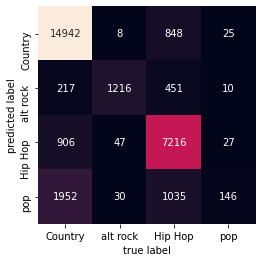

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

EVALUATION OF CLASSIFIER

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)
for n,genre in enumerate(genres):
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

Country_precision: 0.9443215572268218
Country_recall: 0.8293278570239219
Country_fscore: 0.8830969267139479
Country_support: 18017

alt rock_precision: 0.6420274551214361
alt rock_recall: 0.9346656418139893
alt rock_fscore: 0.761189358372457
alt rock_support: 1301

Hip Hop_precision: 0.8804294777940459
Hip Hop_recall: 0.7556020942408377
Hip Hop_fscore: 0.8132536909726137
Hip Hop_support: 9550

pop_precision: 0.046158710085362
pop_recall: 0.7019230769230769
pop_fscore: 0.0866211806585583
pop_support: 208



TESTING

In [ ]:
text_clf.predict(
    [
        "i stand for the red white and blue",
        "flow so smooth they say i rap in cursive",
        "skateboard heres our ride",
        "take my heart and carve it out",
        "there is no end to the madness",
        "sitting on my front porch drinking sweet tea",
        "i believe whatever else you do",
        "sitting on my front porch sippin on cognac",
        "dog died and my pick up truck wont start",
        "im invisible and the drugs wont help",
        "lalala lalalala",
        "i hope you choke in your sleep thinking of me",
        "i wonder what genre a song about data science and naive bayes and hyper parameters and maybe a little scatter plots would be"
    ]
)

array(['Country', 'Hip Hop', 'pop', 'alt rock', 'alt rock', 'Country',
       'pop', 'Hip Hop', 'Hip Hop', 'alt rock', 'pop', 'alt rock',
       'Hip Hop'], dtype='<U8')

In [ ]:
data = train_df.append(test_df)
predicts = text_clf.predict_proba(data.lyric)
data['Country'], data['Hip_Hop'], data['Alt_Rock'], data['Pop'] = ['','','','']
for n,row in enumerate(data.itertuples()):
    data.loc[row.Index, 'Country'] = predicts[n][0]
    data.loc[row.Index, 'Hip_Hop'] = predicts[n][1]
    data.loc[row.Index, 'Alt_Rock'] = predicts[n][2]
    data.loc[row.Index, 'Pop'] = predicts[n][3]

TOP HIP-HOP SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop']
data[columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
15687,Grandmaster_Flash_And_The_Furious_Five,Freedom,Greatest Messages (1984),Hip Hop,1,3.9617e-21,3.05518e-47,2.51354e-19
13481,E-40,End of the World,Grit & Grind (2002),Hip Hop,1,6.85037e-66,1.38575e-70,1.8553e-77
58743,"Tyler,_The_Creator",Where This Flower Blooms,Flower Boy (2017),Hip Hop,1,2.26992e-61,1.58348e-96,2.10273e-89
24790,Lil_Wayne,I'm a D-Boy,Tha Carter II (2005),Hip Hop,1,1.72625e-229,2.16289e-281,3.38788e-272
5831,Proof,Black Wrist Bro's,Searching For Jerry Garcia (2005),Hip Hop,1,1.26687e-143,1.42376e-207,3.25242e-233
19841,Gang_Starr,Hiney,The Ownerz (2003),Hip Hop,1,4.44869e-227,0,2.29148e-320
51867,Drake,The Real Her,Take Care (2011),Hip Hop,1,1.51883e-30,2.52488e-50,6.20559e-33
15376,The_Game,For the Homies,Streets of Compton (2016),Hip Hop,1,2.40501e-51,7.08212e-109,2.76106e-82
36809,Raekwon,North Star (Jewels),Only Built 4 Cuban Linx... (1995),Hip Hop,1,5.71739e-124,2.51884e-178,5.09441e-198
46865,Wiz_Khalifa,Star Power,Star Power (2008),Hip Hop,1,3.25196e-84,2.33875e-101,1.24784e-101


TOP ROCK SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop']
data[columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
23560,Killswitch Engage,I Would Do Anything,Killswitch Engage (2009),alt rock,4.39788e-32,1,2.42772e-23,3.58085e-24
16722,Suicide Silence,Girl of Glass,The Cleansing (2007),alt rock,9.13856e-20,1,2.51937e-18,4.99275e-34
9976,All That Remains,Criticism and Self-Realization,The Order of Things (2015),alt rock,1.63179e-53,1,9.47708e-35,1.98207e-49
49916,Slipknot,The Blister Exists,Vol. 3: (The Subliminal Verses) (2004),alt rock,2.77779e-38,1,1.10815e-56,7.22897e-47
38225,Three Days Grace,One-X,One-X (2006),alt rock,3.73198e-35,1,1.36188e-31,5.61341e-27
26032,Wire,In Vivo,It's Beginning to and Back Again (1989),alt rock,7.60414e-21,1,2.70781e-26,5.30726e-36
15562,Pennywise,Fox TV,The Fuse (2005),alt rock,5.43146e-29,1,4.05353e-52,6.7362e-47
56419,Uriah Heep,Wake Up (Set Your Sights),Very 'Eavy... Very 'Umble (1970),alt rock,2.19064e-33,1,1.29039e-26,1.36069e-24
60431,Blondie,X Offender,Greatest Hits: Sight + Sound (2005),alt rock,2.33905e-35,1,1.13056e-17,4.29256e-26
35057,Alexisonfire,My God Is a Reasonable Man,Crisis (2006),alt rock,3.45188e-14,1,9.5905e-31,1.9705e-55


TOP COUNTRY SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop']
data[columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
45730,Johnny Cash,Sold Out of Flag Poles,One Piece at a Time (1976),Country,2.07136e-35,2.36483e-52,1,1.31586e-104
6738,Charley Pride,Brand New Bed of Roses,Just Plain Charley (1970),Country,1.80875e-27,2.48555e-14,1,6.69518e-17
2655,Tanya Tucker,Almost Persuaded,Best of Tanya Tucker (1992),Country,3.94269e-40,2.97609e-21,1,1.26367e-25
37348,Anne Murray,Oh Lonesome Me,Country Croonin' (2002),Country,1.51578e-54,7.41127e-31,1,2.74194e-25
41875,Alison Krauss,River in the Rain,Windy City (2017),Country,6.61354e-46,3.3857e-19,1,1.23239e-27
12634,Buck Owens,Down to the River,You're for Me (1962),Country,3.76656e-44,3.58759e-14,1,1.00381e-27
10125,Marty Robbins,Crying Steel Guitar Waltz,Song of the Islands (1957),Country,1.22195e-30,2.21095e-16,1,3.51337e-15
48746,George Jones,Talk To Me Lonesome Heart,Country and Western Hits (1961),Country,9.688e-65,1.01277e-33,1,5.16487e-20
42320,Olivia Newton-John,Rosewater,48 Original Tracks (1994),Country,3.58031e-42,7.77439e-14,1,9.0121e-28
57171,Nitty Gritty Dirt Band,We Three Kings,The Christmas Album (1997),Country,4.38791e-38,1.36738e-24,1,1.04404e-28


TOP POP SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop']
data[columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
48741,Hannah Montana,Talk Is Cheap,The Time of Our Lives (2009),pop,1.6783e-18,6.21155e-58,3.12118e-61,1
61653,The Sweet,You're Not Wrong for Loving Me,The Sweet's Biggest Hits (1972),pop,1.79375e-45,3.78383e-30,5.22651e-35,1
4107,Jonas Brothers,BB Good,A Little Bit Longer (2008),pop,7.18986e-59,9.93391e-59,8.64385e-65,1
32356,Jessica Simpson,Loving You,In This Skin (2003),pop,7.05206e-36,5.43867e-21,1.3572e-18,1
33573,Justin Bieber,Memphis,Journals (2013),pop,2.03499e-45,4.60568e-57,1.13774e-57,1
7811,Hanson,Can't Stop,This Time Around (2000),pop,6.5673e-83,3.05356e-50,5.72809e-79,1
11377,Christina Aguilera,Dirrty,Keeps Gettin' Better: A Decade of Hits (2008),pop,7.02478e-59,1.0474e-183,4.7273e-206,1
38325,Bananarama,Only Your Love,Pop Life (1991),pop,1.64208e-57,4.68279e-26,3.47759e-21,1
48200,The Sweet,Sweet F.A.,Sweet Fanny Adams (1974),pop,9.31041e-35,1.99861e-65,1.22693e-35,1
16368,Christina Aguilera,"Get Mine, Get Yours",Stripped (2002),pop,1.63037e-32,3.8358e-52,1.02915e-72,1


MOST ROCK LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
19070,Hopsin,Heather Nicole,RAW (2010),Hip Hop,1.14757e-42,1,8.68552e-48,2.55991e-48
51774,Immortal_Technique,The Poverty Of Philosophy,Revolutionary Vol. 1 (2001),Hip Hop,3.6853e-42,1,5.81842e-185,4.58338e-251
8958,B.o.B,Coastline,Underground Luxury (2013),Hip Hop,4.37718e-39,1,2.10189e-27,9.65814e-43
55514,Immortal_Technique,Ultimas Palabras,The Martyr (2011),Hip Hop,2.44477e-83,1,2.88894e-201,3.15132e-276
26361,Immortal_Technique,Internally Bleeding,Revolutionary Vol. 2 (2003),Hip Hop,2.89781e-21,1,1.30496e-80,9.37078e-109
8958,B.o.B,Coastline,Underground Luxury (2013),Hip Hop,4.37718e-39,1,2.10189e-27,9.65814e-43
19070,Hopsin,Heather Nicole,RAW (2010),Hip Hop,1.14757e-42,1,8.68552e-48,2.55991e-48
11296,Lil_Wayne,Die For You,Rebirth (2010),Hip Hop,6.64783e-36,1,6.65419e-37,2.00586e-14
33568,De_La_Soul,Memory of... (Us),and the Anonymous Nobody... (2016),Hip Hop,6.15778e-18,1,7.302e-22,9.81141e-26
22842,Yelawolf,I See You,Radioactive (2011),Hip Hop,3.65859e-24,1,1.15973e-25,6.68124e-14


MOST COUNTRY LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
49159,Yelawolf,Tennessee Love,Love Story (2015),Hip Hop,5.01273e-26,1.97917e-31,1,4.65422e-44
32231,B.o.B,Lovelier Than You,The Adventures of Bobby Ray (2010),Hip Hop,9.73684e-16,3.92052e-30,1,1.84977e-27
45925,Scarface,Someday,The Fix (2002),Hip Hop,2.22449e-60,5.70185e-14,1,1.42043e-41
27695,DMX,Jesus Loves Me,Walk With Me Now And You'll Fly With Me Later ...,Hip Hop,8.52193e-35,4.60846e-27,1,2.18987e-37
1185,DMX,A Minute For Your Son,The Great Depression (2001),Hip Hop,9.89635e-20,7.57109e-32,1,1.77216e-30
32231,B.o.B,Lovelier Than You,The Adventures of Bobby Ray (2010),Hip Hop,9.73684e-16,3.92052e-30,1,1.84977e-27
3133,DMX,Angel,The DMX Files (2002),Hip Hop,2.5491e-45,1.34766e-25,1,7.6585e-19
18172,T.I.,Hallelujah,Trouble Man: Heavy is the Head (2012),Hip Hop,1.22535e-15,5.31068e-24,1,1.50624e-66
32231,B.o.B,Lovelier Than You,The Adventures of Bobby Ray (2010),Hip Hop,9.73684e-16,3.92052e-30,1,1.84977e-27
32231,B.o.B,Lovelier Than You,The Adventures of Bobby Ray (2010),Hip Hop,9.73684e-16,3.92052e-30,1,1.84977e-27


MOST POP LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
47982,Guru,Supa Love,"Jazzmatazz, Vol. 3: Streetsoul (2000)",Hip Hop,2.02949e-34,7.63757e-62,5.04123e-39,1
30487,Drake,Little Bit,So Far Gone (2009),Hip Hop,1.64846e-26,1.58718e-67,2.75122e-80,1
19083,Nelly,Heaven,M.O. (2013),Hip Hop,3.08524e-37,1.85302e-21,8.98369e-32,1
20796,Lil_Wayne,How to Love,Tha Carter IV (2011),Hip Hop,3.97874e-17,1.2409e-14,3.98187e-22,1
55471,Nelly,U Know U Want To,M.O. (2013),Hip Hop,7.22182e-60,5.4718e-55,1.54722e-63,1
46331,Drake,Sooner Than Later,So Far Gone (2009),Hip Hop,4.07982e-51,9.00189e-25,2.56153e-30,1
39889,Childish_Gambino,Pop Thieves (Make It Feel Good),STN MTN / Kauai (2014),Hip Hop,5.39873e-72,9.11572e-40,8.13137e-49,1
41709,Wiz_Khalifa,Right Here,Deal or No Deal (2009),Hip Hop,7.91434e-33,1.67727e-43,1.47974e-62,1
44814,Drake,Since Way Back,More Life (2017),Hip Hop,7.71248e-27,4.94991e-28,1.25456e-21,1
55341,LL_Cool_J,Two Different Worlds,Walking With A Panther (1989),Hip Hop,1.69082e-22,1.19101e-27,6.64365e-21,1


MOST HIP-HOP LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
40518,New York Dolls,Puss n' Boots,"Live from Royal Festival Hall, 2004 (2004)",alt rock,1,7.2317e-19,4.97053e-19,2.75343e-23
31341,Blood on the Dance Floor,"Looking Hot, Dangerous",Epic (2010),alt rock,1,3.30537e-27,1.43216e-159,2.58277e-76
15961,NOFX,Fun Things to Fuck (If You're a Winner),45 or 46 Songs That Weren't Good Enough to Go ...,alt rock,1,5.868e-15,1.17393e-101,1.10893e-59
46662,Slipknot,Spit It Out,Slipknot (1999),alt rock,1,4.26777e-18,3.49112e-125,3.02206e-90
5996,Blood on the Dance Floor,Blood On The Dance Floor,Let's Start A Riot (2007),alt rock,1,8.57979e-26,6.60177e-99,2.58519e-55
18075,The Vandals,H.B. Hotel,Sweatin To The Oldies (1994),alt rock,1,1.93204e-15,8.83234e-64,1.48457e-71
56682,Hollywood Undead,War Child,Day of the Dead (2015),alt rock,1,7.27021e-42,1.0224e-132,7.52396e-78
52947,The Bouncing Souls,These Are The Quotes from Our Favorite 80's Mo...,The Good The Bad And The Argyle (1994),alt rock,1,3.05107e-24,6.52915e-33,2.21739e-23
35735,Nirvana,Negative Creep,Bleach (1989),alt rock,1,1.72837e-17,1.44928e-22,3.99091e-22
16140,Hollywood Undead,Gangsta Sexy,American Tragedy (2011),alt rock,1,3.52638e-181,5.4254e-272,8.08411e-180


MOST COUNTRY LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
50325,Dropkick Murphys,The Dirty Glass,Blackout (2003),alt rock,9.86754e-95,1.07231e-47,1,6.13628e-100
42683,The Replacements,Sadly Beautiful,All for Nothing/Nothing for All (1997),alt rock,3.91209e-24,4.81164e-14,1,1.22594e-27
55432,Yellowcard,Two Weeks From Twenty,Lights and Sounds (2006),alt rock,1.17665e-37,2.0039e-15,1,4.92114e-36
44960,Nickelback,Sister Sin,No Fixed Address (2014),alt rock,1.44639e-49,5.51166e-22,1,1.16461e-42
7998,The Velvet Underground,Caroline,Squeeze (1973),alt rock,7.83293e-62,1.80814e-25,1,7.67362e-28
53970,UFO,Time on My Hands,Phenomenon (1974),alt rock,9.77945e-22,1.49867e-17,1,1.17274e-15
29874,Joan Jett and the Blackhearts,Let's Do It,Jett Rock (2003),alt rock,4.44077e-16,1.78536e-17,1,2.72485e-31
36825,Panic! at the Disco,Northern Downpour,Pretty. Odd. (2008),alt rock,4.937e-55,1.40371e-13,1,4.25434e-36
47863,Joan Jett and the Blackhearts,Summertime Blues,I Love Rock 'n Roll (1981),alt rock,9.90574e-26,1.67764e-17,1,1.56777e-17
9558,iwrestledabearonce,Corey Feldman Holocaust,Iwrestledabearonce EP (2007),alt rock,3.25469e-70,3.49676e-28,1,4.27985e-74


MOST POP LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
5292,Black Flag,Best One Yet,Loose Nut (1985),alt rock,1.93581e-40,1.10082e-15,3.76443e-24,1
44813,A Day To Remember,Since U Been Gone,Attack of the Killer B-Sides (2010),alt rock,1.17039e-24,1.93825e-17,3.02972e-17,1
39958,Sleeping With Sirens,Postcards and Polaroids,Let's Cheers to This (2011),alt rock,5.19781e-63,4.20885e-26,1.39893e-35,1
11696,Joan Jett and the Blackhearts,Do You Wanna Touch Me (Oh Yeah),Do You Wanna Touch Me (1993),alt rock,1.67068e-72,5.54355e-56,4.07534e-81,1
26392,Sonic Youth,Into the Groove(y),The Whitey Album (1989),alt rock,1.36109e-35,4.25602e-19,4.2846e-27,1
32376,Sleeping With Sirens,Low,Feel (2013),alt rock,4.97678e-48,9.52701e-23,2.05572e-33,1
11707,Joan Jett and the Blackhearts,Do You Want To Touch Me (Oh Yeah),Bad Reputation (1981),alt rock,1.67068e-72,5.54355e-56,4.07534e-81,1
3447,Rise Against,Any Way You Want It,Long Forgotten Songs: B-Sides & Covers 2000-20...,alt rock,5.42181e-57,3.89678e-33,1.49363e-21,1
42328,Danzig,Rough Boy,Skeletons (2015),alt rock,7.13623e-23,1.88492e-19,2.00564e-25,1
57030,Less Than Jake,We Go Together,Greased (1996),alt rock,7.92003e-50,6.07603e-88,3.20373e-171,1


MOST HIP-HOP LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
38230,Brad Paisley,Online,5th Gear (2007),Country,1,4.47339e-31,5.2957e-61,5.32694e-31
48014,Willie Nelson,Superman,Lost Highway (2009),Country,1,1.14383e-18,1.00978e-14,4.65628e-19
16425,Blake Shelton,Get Some,Red River Blue (2011),Country,1,1.10706e-18,1.8905e-14,3.80052e-18
16763,Elvis Presley,Girls! Girls! Girls!,"Girls, Girls, Girls! (1962)",Country,1,8.36301e-21,1.04309e-18,3.44134e-22
18681,Clint Black,Haywire,Spend My Time (2004),Country,1,2.56353e-21,7.98296e-26,3.81788e-44
17002,Eddie Rabbitt,Go To Sleep Big Bertha,The Best Year of My Life (1984),Country,1,2.66306e-30,6.09859e-15,1.5269e-50
10792,John Denver,Deal With The Ladies,Higher Ground (1989),Country,1,4.70668e-27,3.9034e-18,2.40336e-41
19061,Eddie Rabbitt,"Heat 'Em Up, Eat 'Em Up",Songs from Rabbittland (1998),Country,1,6.26891e-24,6.81683e-22,3.03304e-17
30415,John Denver,Lining Track,All Aboard (1997),Country,1,9.47233e-70,6.54333e-14,2.33627e-68
2960,Toby Keith,American Ride,American Ride (2009),Country,1,2.02629e-17,5.24148e-14,1.64699e-44


MOST ROCK LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
32885,Garth Brooks,Man Against Machine,Man Against Machine (2014),Country,1.06122e-26,1,2.3461e-24,4.07381e-54
24861,"Hank Williams, Jr.",I'm for Love,Hank Live (1987),Country,5.52198e-23,1,2.91258e-20,5.35383e-42
11989,Willie Nelson,Don't Fade Away,Stars & Guitars (2002),Country,1.04487e-64,1,7.55275e-17,3.33066e-15
39973,John Denver,Potter's Wheel,Different Directions (1991),Country,2.10259e-37,1,4.06918e-23,4.90138e-39
50650,Johnny Cash,The Gettysburg Address,America: A 200-Year Salute in Story and Song (...,Country,2.35059e-25,1,3.02415e-16,4.79404e-65
8830,Taylor Swift,Clean,1989 (2014),Country,1.92392e-32,1,7.80303e-14,2.034e-22
24860,"Hank Williams, Jr.",I'm for Love,Five-O (1985),Country,5.52198e-23,1,2.91258e-20,5.35383e-42
46837,Garth Brooks,Standing Outside The Fire,The Ultimate Hits (2007),Country,2.45297e-43,1,6.77593e-17,6.5562e-25
41207,Johnny Cash,Redemption Song,Unearthed (2003),Country,1.04247e-26,1,3.99392e-19,5.31945e-64
31170,Olivia Newton-John,Long Live Love (German Version),"If You Love Me, Let Me Know (1974)",Country,1.31777e-158,1,1.27979e-133,3.09017e-168


MOST POP LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
60922,Sara Evans,You Don't,Born To Fly (2000),Country,3.48443e-28,1.82833e-14,4.52282e-16,1
21311,Dolly Parton,"I Can't Help Myself (Sugar Pie, Honey Bunch)",Think About Love (1986),Country,5.72619e-41,1.38426e-21,2.06967e-16,1
16810,Don Williams,Give It to Me,Expressions (1978),Country,1.13264e-45,2.39392e-18,4.61143e-17,1
29871,Sara Evans,Let's Dance,Born To Fly (2000),Country,9.90126e-55,1.47735e-18,2.72963e-24,1
20612,Ronnie Milsap,How Do I Turn You On,Lost in the Fifties Tonight (1986),Country,5.23216e-40,6.57901e-17,1.41653e-19,1
41713,Olivia Newton-John,Right Here With You,A Celebration in Song (2008),Country,2.85941e-51,9.88674e-17,8.91315e-20,1
17469,Eddie Rabbitt,Good Night For Falling In Love,Radio Romance (1982),Country,1.15019e-59,4.32195e-21,1.24753e-17,1
25350,Sara Evans,If I Run,Slow Me Down (2014),Country,4.53528e-44,1.08435e-14,8.74429e-21,1
61739,Martina McBride,You're in My House Now,Eleven (2011),Country,1.76858e-73,2.31255e-30,6.19869e-46,1
48313,Sara Evans,Sweet Spot,Slow Me Down (2014),Country,4.52046e-27,2.09023e-16,1.12069e-40,1


MOST HIP-HOP LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
52599,The Naked Brothers Band,The World (As We Know It Today),Throwbacks (2013),pop,1,5.73606e-25,7.49574e-59,1.70503e-17
12478,Hannah Montana,Dooo It!,Miley Cyrus & Her Dead Petz (2015),pop,1,1.53321e-34,9.40056e-80,2.44975e-21
7004,'N Sync,Bringin' da Noise,No Strings Attached (2000),pop,1,2.1183e-85,2.64261e-104,1.77684e-22
28199,'N Sync,Just Got Paid,No Strings Attached (2000),pop,1,1.05988e-55,3.65839e-69,2.49224e-19
52599,The Naked Brothers Band,The World (As We Know It Today),Throwbacks (2013),pop,1,5.73606e-25,7.49574e-59,1.70503e-17
44529,Christina Aguilera,Shut Up,Lotus (2012),pop,1,5.89548e-20,2.37395e-119,3.71917e-28
42580,Giorgio,Rush Rush,Scarface (1983),pop,1,9.57802e-64,6.10494e-58,8.40441e-93
29453,Aaron Carter,Leave It Up To Me,Most Requested Hits (2003),pop,1,4.22194e-67,2.88099e-110,6.51321e-60
4478,Hannah Montana,Backwards (Acoustic),Hannah Montana: The Movie (2009),pop,1,5.01285e-24,3.5729e-15,1.77362e-20
44529,Christina Aguilera,Shut Up,Lotus (2012),pop,1,5.89548e-20,2.37395e-119,3.71917e-28


MOST ROCK LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
43458,Katy Perry,Self Inflicted,One of the Boys (2008),pop,5.64839e-36,1,4.17066e-48,3.4143e-15
43458,Katy Perry,Self Inflicted,One of the Boys (2008),pop,5.64839e-36,1,4.17066e-48,3.4143e-15
4339,Aqua,Back From Mars,Aquarius (2000),pop,5.21238e-20,1,3.28273e-18,7.37817e-24
483,The Naked Brothers Band,18,Black Sheep (2011),pop,1.12908e-40,1,9.59093e-18,9.63591e-35
11517,Backstreet Boys,Divine Intervention,Never Gone (2005),pop,1.38785e-35,1,1.3162e-27,6.62161e-15
60248,Hanson,World's on Fire,"Stand Up, Stand Up (2009)",pop,5.12715e-42,1,2.66343e-25,1.1433e-14
11928,Jonas Brothers,Don't Charge Me for the Crime,"Lines, Vines and Trying Times (2009)",pop,6.19013e-18,1,5.46976e-27,4.44335e-19
42584,Toy-Box,Russian Lullaby,Toy Ride (2001),pop,1.55899e-43,1,2.84848e-15,5.50631e-22
58615,Hanson,Where Did It Start,Take the Walk (2008),pop,4.23602e-40,1,1.33757e-19,1.25788e-14
11517,Backstreet Boys,Divine Intervention,Never Gone (2005),pop,1.38785e-35,1,1.3162e-27,6.62161e-15


MOST COUNTRY LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop
44548,Tommy James & the Shondells,Shy Boy,Discography: Deals & Demos '74-'92 (1993),pop,6.60368e-54,5.21695e-42,1,2.09509e-17
44548,Tommy James & the Shondells,Shy Boy,Discography: Deals & Demos '74-'92 (1993),pop,6.60368e-54,5.21695e-42,1,2.09509e-17
57533,The Monkees,What Am I Doing Hangin' 'Round?,"Pisces, Aquarius, Capricorn & Jones Ltd. (1967)",pop,4.93012e-58,1.89771e-52,1,4.24297e-20
37334,'N Sync,Oh Holy Night (A Cappella),Home For Christmas (1998),pop,6.67388e-48,1.54765e-14,1,2.19497e-17
44677,Hanson,Silent Night Medley,Snowed In (1997),pop,5.47745e-78,9.37563e-28,1,1.12872e-20
50737,The Monkees,The Good Earth,The Monkees Present (1969),pop,1.30405e-46,7.41807e-15,1,7.49255e-22
57534,The Monkees,What Am I Doing Hangin' 'Round?,Then And Now... The Best Of The Monkees (1986),pop,4.93012e-58,1.89771e-52,1,4.24297e-20
53103,Bucks Fizz,Thief In The Night,I Hear Talk (1984),pop,1.71076e-77,1.62439e-13,1,3.20487e-17
18803,Bananarama,He's Got Tact,Deep Sea Skiving (1983),pop,3.48157e-26,6.33743e-28,1,1.34034e-14
24402,Giorgio,"I'm Left, You're Right, She's Gone",From Here to Eternity (1977),pop,8.18861e-101,7.73993e-32,1,9.37879e-16


In [ ]:
from wordcloud import WordCloud, STOPWORDS 


In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 

COUNTRY WORD CLOUD

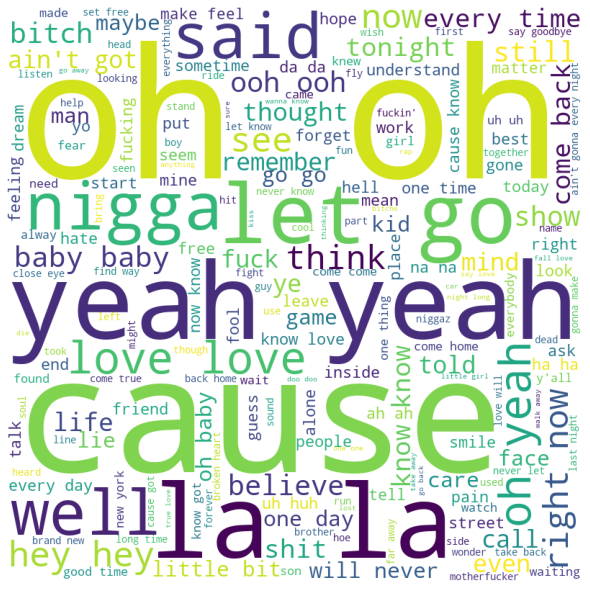

In [ ]:
if([lyrics_by_song.ranker_genre=='Country']):
  for val in df.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  plt.show() 

HIP HOP:

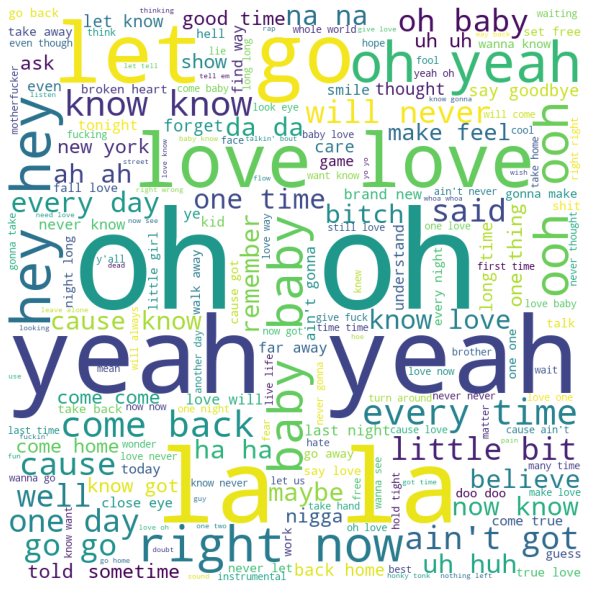

In [ ]:
if([lyrics_by_song.ranker_genre=='Hip Hop']):
  for val in df.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  plt.show()

In [ ]:
ALT ROCK

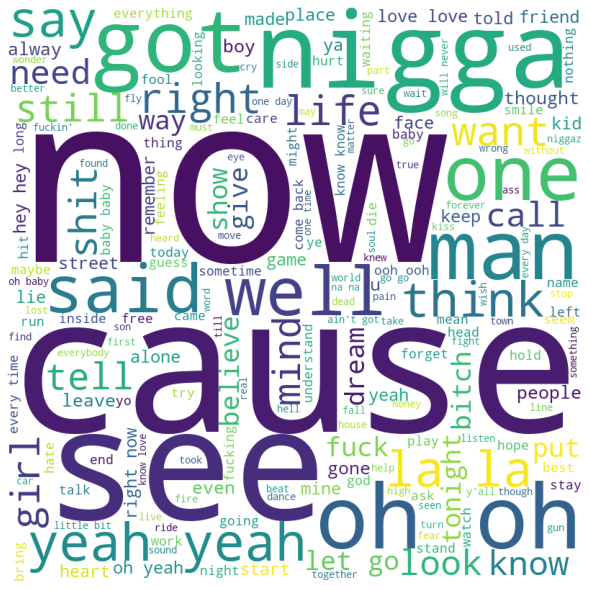

In [ ]:
if([lyrics_by_song.ranker_genre=='alt rock']):
  for val in df.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  plt.show()

In [ ]:
POP

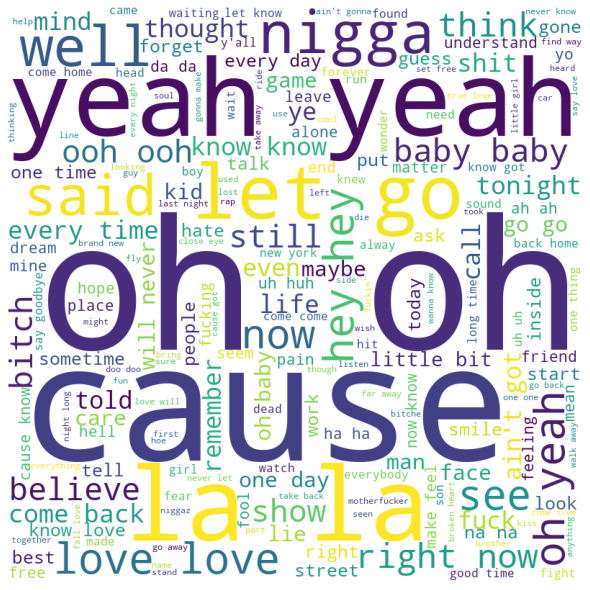

In [ ]:
if([lyrics_by_song.ranker_genre=='pop']):
  for val in df.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  plt.show()